# Q-Learning with Table 🤖 🎛 🍽
> This is a demo of Q-learning at its simplest for solving Reinforcement Learning (RL) problems. The challenge here is a frozen lake that is being solved via **table** approach for Q-learning implementation. It serves as an example code for an [introduction story into RL on Medium](https://medium.com).

<img src="img/table-wall-e.png" alt="Drawing" style="width: 400px;"/>

## 1) Environment 🗺
It is a [frozen lake by Gym OpenAI](https://gym.openai.com/envs/FrozenLake-v0/), in which an agent tries to find a safe path across a grid of slippery ice and water tiles to get the ultimate reward.

In [ ]:
'''
.--------------------.
| 🐹 | ❄️ | ❄️ | ❄️ | 
|- - - - -  - - - - -|
| ❄️ | 🕳 | ❄️ | 🕳 |
|- - - - -  - - - - -|
| ❄️ | ❄️ | ❄️ | 🕳 |
|- - - - -  - - - - -|
| 🕳 | ❄️ | ❄️ | 🥜 |
.--------------------.
'''

The environment is depicted in the picture above as a 4x4 grid world with 16 possible states. There is a hamster that tries to munch on peanuts. Its **goal is to reach those peanuts**!
* this little fellow can choose to go one of **4 directions (actions) on the ice at each grid cell (state)**, i.e. it can go either up, down, left, or right
* it tries to **avoid going into water holes**, which results in sinking and therefore an unsuccessful attempt
* however, it is not that easy since there is a chance that this little creature can **randomly slip on ice and go into different grid cells** than wanted
* the **success or failure** for solving the frozen lake is defined by this hamster getting those peanuts or sinking into the water hole, respectively

## 2) Algorithm 🎰
It is a classic Q-learning algorithm that goes through iteration steps to experience the environment. After certain amount of episodes, it ultimately finds the best state-action pairs Q(s,a) for the algorithm, the so called "Q-values". The Q-values represent how good it is for an agent (🐹) to be in state in terms of getting the long term reward (🥜). This algorithm has various implementations depending on which policy is chosen for taking actions or how Q-values are processed. The picture below shows an overview on the implementation of this model-free algorithm from the Temporal Difference learning (TD) method [Sutton & Barto 2017].

![title](img/algo-method.png)
> _... let's see the implementation!_ 🛠

### Table 🍽
The Q-values are stored in the **Q-table** and are updated during training of the algorithm. This table has rows representing states (s) and columns representing possible actions (a). It is initialized with some values at start and gets populated with different values as the algorithm proceeds. It ultimately reaches some optimal values for an agent to choose (higher Q-values are better), once it has learned how to solve the environment. This means that Q-values are learned after a certain amount of episodes (training steps/iterations) & can be then used to play the game (solve the environment) better than without any prior training.

In [ ]:
'''
     U   D   L   R
   .---------------.
0  | 0 | 0 | 0 | 0 | 
   | - - - - - - - |
1  | 0 | 0 | 0 | 0 |
   | - - - - - - - |
2  | 0 | 0 | 0 | 0 |
   | - - - - - - - |
.. | . | . | . | . |
   | - - - - - - - |
15 | 0 | 0 | 0 | 0 |
   .---------------.
'''

The Q-table for our case is shown in the drawing above.
* it will have **4 columns** representing possible actions (U for up, D for down, L for left, R for right) & **16 rows** representing all states for this environment
* the Q-table is **initialized with zeros** at start of training

#### estimation ⏳
We will use the equation below to estimate the Q-values for the table scenario of Q-learning. This equation is just rewritten from the earlier introduced definition of Q-learning. It somehow expresses the learning process by the following observation. The first term on the right-hand side, is the reduced learning rate (1 - α) multiplied by the old Q-value (current knowledge). Then, this is added to the learning rate (α) multiplied by the learned value (new knowledge). The learned value is the last term in parenthesis on the right-hand side, that contains rewards (R) and discounted best actions for the new (observed) state.

<img src="img/algo-estimation.png" alt="Drawing" align="left" style="width: 650px;"/>

* the **learning rate (α) can take values between 0 to 1**, where value of one means an agent tries to learn everything (exploration by ignoring prior knowledge) & value of zero means an agent learns nothing (exploitation of prior knowledge)
* the **discount factor (ɣ) can take values between 0 to 1**, where value of one means it is considering only long-term rewards (an agent is farsighted) & value of zero means it is considering only the current rewards (an agent is nearsighted)

### Bandit 🔫 🤠 🐴
We will create an agent that **chooses actions** as if it were a **multiarmed bandit**. It is a famous problem from probability theory that was used to address decisions of gamblers playing slot machines in casinos. Here, tt can help us to address the exploration-exploitation dilemma in RL. This bandit will choose actions from supplied Q-values for a given state.
* the bandit will have **4 arms**, since we have 4 actions to choose at each state
* we will use the **epsilon-greedy** strategy for the bandit, i.e. our agent will randomly choose actions by flipping a coin so as to either go explore or exploit the environment
* the **epsilon can take values between 0 to 1**, where 0 means an agent will do no exploration whatsoever (100% exploitation) and 1 is all about exploration (0% exploitation)

## 3) Code 💻
We will **train** the Q-learning for certain amount of episodes in the environment and then try to **play** the game with learned Q-values by training.

### training 🏋️‍ 
> _... let's train the algorithm to solve the environment_

_... load the Python **packages**_

In [1]:
import gym
import mxnet as mx
import matplotlib.pyplot as plt
import random
from time import time

_... set the **hyperparameters** for the model_

In [2]:
EPISODES = 2000
STEPS = 100
BANDIT_ARMS = 4
BANDIT_TRAINING = True
EPSILON = 1 # setting the agent for exploration only -> try to learn the environment
ALPHA = 0.8
GAMMA = 0.95

_... load the test environment of **frozen lake**_ & get its possible number of _**states and actions**_

In [3]:
env = gym.make('FrozenLake-v0')
states = env.observation_space.n
actions = env.action_space.n

_... create the **Q-table**_

In [4]:
# -> make the Q-table with the same dimensions as the test environment & initialize it with zero Q-values
Q = mx.nd.zeros(shape=(states, actions), ctx=mx.cpu(), dtype='float32')

_... define the **epsilon-greedy bandit**_

In [5]:
def run_epsilon_greedy_bandit(arm_rewards, arms, training, epsilon, episode):
    # check if bandit is used for training
    if training:
        # -> start with the full exploration and slowly reduce it as this algorithm learns with each training episode
        epsilon = mx.nd.exp(data=mx.nd.array([-0.01 * episode]))
    
    # flip the coin (randomly select the number between 0 to 1)
    random_number = random.random()

    # select the arm
    if random_number > epsilon:
        # Exploit
        # -> find arms with highest rewards
        max_reward_arms = [i for i, e in enumerate(arm_rewards) if e == max(arm_rewards)]
        # -> select the best arm
        if len(max_reward_arms) == 1:
            # get the best arm
            arm = max_reward_arms[0]
        else:
            # randomly choose an arm from the best arms
            arm = random.choice(max_reward_arms)
    else:
        # Explore
        # -> randomly choose an arm
        arm = random.randrange(arms)
        
    return arm

_... run the **Q-learning** for the test environment_

In [6]:
# log the training start
training_start = time()

# store the training progress of this algorithm for each episode
episode_rewards = []
episode_steps = []

# solve the environment over certain amount of episodes
for episode in range(EPISODES):
    # reset the environment, rewards, and steps for the new episode
    s = env.reset()
    episode_reward = 0
    step = 0
    
    # find the solution over certain amount of attempts (steps in each episode)
    while step < STEPS:
        # select the action by running the multiarmed bandit with epsilon-greedy strategy
        a = run_epsilon_greedy_bandit(Q[s, :], BANDIT_ARMS, BANDIT_TRAINING, EPSILON, episode)
        
        # enter the environment and get the experience from it by performing there a specific action
        # -> get the observation (new state), reward, done (success/failure), and information from this environment
        observation, reward, done, info = env.step(a)

        # update the Q-values for the current state with the experience from this environment 
        Q[s, a] = Q[s, a] + ALPHA * (reward + GAMMA * mx.nd.max(Q[observation, :]) - Q[s, a])

        # add the reward to others during this episode
        episode_reward += reward
        
        # change the state to the observed state for the next iteration
        s = observation

        # check if the environment has been exited
        if done:
            # -> append the collected rewards & number of steps in this episode to training progress     
            episode_rewards.append(episode_reward)
            episode_steps.append(step)
            # -> quit the episode
            break

        # continue looping
        step += 1

# log the training end
training_end = time()

_... print the **final Q-values**_

In [7]:
print("trained Q-values", Q)

trained Q-values 
[[1.79598913e-01 1.54694039e-02 2.25188620e-02 2.09673196e-02]
 [6.58146292e-03 4.87169437e-03 3.93946655e-03 1.95556760e-01]
 [2.14494718e-03 3.14381020e-03 3.11068678e-03 1.20347328e-01]
 [2.12319940e-03 2.80981418e-03 2.95142923e-03 5.73039055e-02]
 [3.38882297e-01 1.12175941e-02 3.08078807e-03 2.16190070e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.09232920e-02 1.17122145e-05 4.72419924e-05 1.42741010e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.03123787e-03 6.84876228e-03 3.71048320e-03 5.25624394e-01]
 [5.70514053e-03 6.36591673e-01 1.75280031e-03 3.54621094e-03]
 [4.88883197e-01 7.17768213e-04 9.19382437e-04 6.79788878e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.64733367e-03 3.44705731e-02 2.24181280e-01 7.66693652e-02]
 [1.92024857e-02 8.91893387e-01 1.20218888e-01 1.01679184e-01]
 [0.00000000e+00 0.00000000e+00 0.000

_... print the **training progress** of the algorithm_


This environment has been solved 56.25 % of times over 2000 episodes within 137 seconds!


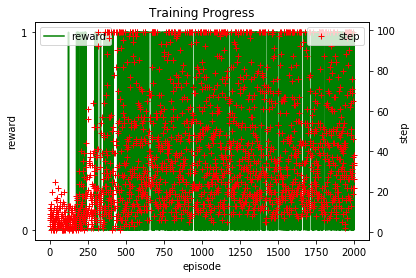

In [8]:
# show the success rate for solving the environment & elapsed training time
success_rate = round((sum(episode_rewards) / EPISODES) * 100, 2)
elapsed_training_time = int(training_end - training_start)
print("\nThis environment has been solved", str(success_rate), "% of times over",  str(EPISODES), "episodes within", str(elapsed_training_time), "seconds!")

# plot the rewards and number of steps over all training episodes
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(episode_rewards, '-g', label = 'reward')
ax1.set_yticks([0,1])
ax2 = ax1.twinx()
ax2.plot(episode_steps, '+r', label = 'step')
ax1.set_xlabel("episode")
ax1.set_ylabel("reward")
ax2.set_ylabel("step")
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.title("Training Progress")
plt.show()

>_... the training progress of this algorithm can be seen from the figure above, where each episode finishes either with value 0 or 1 as a reward -> this means that our agent 🐹 fell into the ice hole 🕳 or found those peanuts 🥜, respectively_
> * the **algorithm is able to solve the environment more often as it learns** and starts exploiting its own knowledge more with increasing episodes
> * with increasing episodes, **our agent also survives longer in the environment** without falling into the ice hole and eventually reaches the reward... how efficiently it reaches the goal is questionable though, since the ice is slippery and not being dead under it is probably important too :)

### playing 🎮
> _... let's play the game to see how our agent 🐹 solves the environment with the knowledge obtained from training, i.e. with the trained Q-values_

_... set the **hyperparameters for the game**_

In [9]:
GAME_EPISODES = 10
BANDIT_TRAINING = False
EPSILON = 0 # setting the agent for pure exploitation -> use only learned Q values from training

_... let's **play the game**_

In [10]:
for episode in range(GAME_EPISODES):
    s = env.reset()
    step = 0
    while step < STEPS:
        # Take the action (index) that have the maximum expected future reward given that state
        a = run_epsilon_greedy_bandit(Q[s, :], BANDIT_ARMS, BANDIT_TRAINING, EPSILON, episode)
        
        # enter the environemnt and get the experience from it
        observation, reward, done, info = env.step(a)

        # change the state to observed state for the next iteration
        s = observation

        # check if the environment has been exited
        if done:
            # print stats of game (episode, steps, and the last agent's state)
            print("\n-----------------------------")
            print(step, "steps in episode", episode)
            print("The last action & state was:")
            env.render()
            print("-----------------------------")
            # - quit the episode
            break

        # continue looping
        step += 1


-----------------------------
61 steps in episode 0
The last action & state was:
  (Down)
SFFF
FHFH
FFFH
HFFG
-----------------------------

-----------------------------
66 steps in episode 1
The last action & state was:
  (Down)
SFFF
FHFH
FFFH
HFFG
-----------------------------

-----------------------------
73 steps in episode 2
The last action & state was:
  (Down)
SFFF
FHFH
FFFH
HFFG
-----------------------------

-----------------------------
99 steps in episode 3
The last action & state was:
  (Left)
SFFF
FHFH
FFFH
HFFG
-----------------------------

-----------------------------
46 steps in episode 4
The last action & state was:
  (Down)
SFFF
FHFH
FFFH
HFFG
-----------------------------

-----------------------------
49 steps in episode 5
The last action & state was:
  (Down)
SFFF
FHFH
FFFH
HFFG
-----------------------------

-----------------------------
62 steps in episode 6
The last action & state was:
  (Down)
SFFF
FHFH
FFFH
HFFG
-----------------------------

------------

<img src="img/conclusions-wall-e.png" alt="Drawing" style="width: 500px;"/>

## Conclusions 🤔
We have built a simple table model for Q-learning solving an RL problem of a frozen lake. As seen from running the code, our model learns during training and then takes advantage of such prior experience when solving the environment during playing. You can tweak the hyperparameters for learning rate & discount factor, or even implement different bandit strategies for choosing actions to see if it learns better during training.

## References
* R. S. Sutton and A. G. Barto: "Reinforcement Learning: An Introduction", 2nd edition, A Bradford Book, 2017